In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold

## Load data

In [9]:
Y_total = np.loadtxt('data/data.txt').astype(int)
Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)
movies = np.loadtxt('data/movies.txt', dtype='str', delimiter='\t')
movie_names = dict([(int(movie[0]), movie[1]) for movie in movies])
movie_labels = movies[:,2:].astype('float')
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

In [24]:
def get_err(U, V, Y, reg=0.0, use_bias=False, a=None, b=None):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V. a is the vector of biases for each user and
    b is the vector of biases for each movie.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    reg_term = reg * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2) / 2
    err = 0 
    for y in Y:
        i = y[0] - 1
        j = y[1] - 1
        Y_ij = y[2]
        if use_bias:
            err += (Y_ij - np.dot(U[i], V[j]) - a[i] - b[j])**2
        else:
            err += (Y_ij - np.dot(U[i], V[j]))**2
    return (reg_term + (err / 2) )/ float(len(Y))

## Method 1 function definitions & training

In [39]:
def grad_U(Ui, Yij, Vj, reg, eta, use_bias=False, ai=None, bj=None):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    if use_bias:
        grad = - Vj * (Yij - np.dot(Ui, Vj) - ai - bj)
    else:
        grad = - Vj * (Yij - np.dot(Ui, Vj))
    return (Ui * reg + grad) * eta

def grad_V(Vj, Yij, Ui, reg, eta, use_bias=False, ai=None, bj=None):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    if use_bias:
        grad = - Ui * (Yij - np.dot(Ui, Vj) - ai - bj)
    else:
        grad = - Ui * (Yij - np.dot(Ui, Vj))
    return (Vj * reg + grad) * eta

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.rand(M, K) - 0.5
    V = np.random.rand(N, K) - 0.5

    for epoch in range(max_epochs):
        
        curr_loss = get_err(U, V, Y, reg)

        rand_perm = np.random.permutation(list(range(len(Y))))
        for index in rand_perm:
            i = Y[index][0] - 1
            j = Y[index][1] - 1
            Y_ij = Y[index][2]
            Ui = U[i]
            Vj = V[j]
            U[i] -= grad_U(Ui, Y_ij, Vj, reg, eta)
            V[j] -= grad_V(Vj, Y_ij, Ui, reg, eta)


        if epoch == 1:
            first_dec = curr_loss - get_err(U, V, Y, reg)

        elif epoch > 1:
            dec = curr_loss - get_err(U, V, Y, reg)

            if dec <= eps * first_dec:
                break
    
    return (U, V, get_err(U, V, Y))
    

In [36]:
# Find optimal hyperparameters for learning rate and regularization using cross validation
etas = [0.02, 0.05, 0.08]
regs = [0.0, 0.01, 0.1]

param_grid = []
for eta in etas:
    for reg in regs:
        param_grid.append((eta, reg))
kf = KFold(n_splits = 3)

errors = []
for train_index, test_index in kf.split(Y_train):
    Y_tr, Y_val = Y_train[train_index], Y_train[test_index]
    for eta, reg in param_grid:
        U, V, train_err = train_model(M,N,20,eta,reg,Y_tr)
        errors.append([(eta, reg), get_err(U, V, Y_val)])
    print('split finished')


results = []
for params in param_grid:
    avg = np.mean([err[1] for err in errors if err[0] == params])
    results.append([params, avg])
    
results = sorted(results, key = lambda x: x[1])
best_params = results[0][0]
print(results)
print(best_params)

U_method1, V_method1, train_err = train_model(M,N,20,best_params[0],best_params[1],Y_train)
print('Test error:', get_err(U_method1, V_method1, Y_test))
U_method1, V_method1, err_method1 = train_model(M,N,20,best_params[0],best_params[1],Y_total)


split finished
split finished
split finished
[[(0.02, 0.01), 0.79922974375104905]]
(0.02, 0.01)
Test error: 0.601242217274


## Method 2 function definitions & training

In [ ]:
def grad_a(Ui, Yij, Vj, reg, eta, ai, bj):
    grad = -(Yij - np.dot(Ui, Vj) - ai - bj)
    return (reg * ai + grad) * eta

def grad_b(Ui, Yij, Vj, reg, eta, ai, bj):
    grad = -(Yij - np.dot(Ui, Vj) - ai - bj)
    return (reg * bj + grad) * eta

def train_model_use_bias(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    U = np.random.rand(M, K) - 0.5
    V = np.random.rand(N, K) - 0.5
    a = np.random.rand(M,) - 0.5
    b = np.random.rand(N,) - 0.5

    for epoch in range(max_epochs):
        curr_loss = get_err(U, V, Y, reg, use_bias=True, a=a, b=b)

        rand_perm = np.random.permutation(list(range(len(Y))))
        for index in rand_perm:
            i = Y[index][0] - 1
            j = Y[index][1] - 1
            Y_ij = Y[index][2]
            Ui = U[i]
            Vj = V[j]
            ai = a[i]
            bj = b[j]
            U[i] -= grad_U(Ui, Y_ij, Vj, reg, eta, use_bias=True, ai=ai, bj=bj)
            V[j] -= grad_V(Vj, Y_ij, Ui, reg, eta, use_bias=True, ai=ai, bj=bj)
            a[i] -= grad_a(Ui, Y_ij, Vj, reg, eta, ai, bj)
            b[j] -= grad_b(Ui, Y_ij, Vj, reg, eta, ai, bj)


        if epoch == 1:
            first_dec = curr_loss - get_err(U, V, Y, reg, use_bias=True, a=a, b=b)

        elif epoch > 1:
            dec = curr_loss - get_err(U, V, Y, reg, use_bias=True, a=a, b=b)

            if dec <= eps * first_dec:
                break
    
    return (U, V, a, b, get_err(U, V, Y, reg, use_bias=True, a=a, b=b))

In [ ]:
etas = [0.02, 0.05, 0.08]
regs = [0.0, 0.01, 0.1]

param_grid = []
for eta in etas:
    for reg in regs:
        param_grid.append((eta, reg))
kf = KFold(n_splits = 3)

errors = []
for train_index, test_index in kf.split(Y_train):
    Y_tr, Y_val = Y_train[train_index], Y_train[test_index]
    for eta, reg in param_grid:
        U, V, a, b, train_err = train_model_use_bias(M,N,20,eta,reg,Y_tr)
        errors.append([(eta, reg), get_err(U, V, Y_val, use_bias=True, a=a, b=b)])
    print('split finished')
    
results = []
for params in param_grid:
    avg = np.mean([err[1] for err in errors if err[0] == params])
    results.append([params, avg])
    
results = sorted(results, key = lambda x: x[1])
best_params = results[0][0]
print(results)
print(best_params)

U_method2, V_method2, a, b, train_err = train_model_use_bias(M,N,20,best_params[0],best_params[1],Y_train)
print('Test error:', get_err(U_method1, V_method1, Y_test, use_bias=True, a=a, b=b))
U_method2, V_method2, a, b, err_method2 = train_model_use_bias(M,N,20,best_params[0],best_params[1],Y_total)


## Visualize projections

In [ ]:
def plot_projections(U_in, V_in, U_indices=False, V_indices=False):
    U = np.zeros(U_in.shape)
    V = np.zeros(V_in.shape)
    
    # Normalize
    for i in range(len(V[0])):
        avg = V_in[:,i].mean()
        std = V_in[:,i].std()
        V[:,i] = (V_in[:,i] - avg) / std
        U[:,i] = (U_in[:,i] - avg) / std


    A, Sigma, B = np.linalg.svd(V.T)
    Vproj = np.dot(A[:,:2].T, V.T)
    Uproj = np.dot(A[:,:2].T, U.T)
    

        
    Vproj_new = [[],[]]
    Uproj_new = [[],[]]
    V_names = []
    
    for i in range(2):
        if type(V_indices) is not bool:
            for idx in V_indices:
                Vproj_new[i].append(Vproj[i][idx])

        if type(U_indices) is not bool:
            for idx in U_indices:
                Uproj_new[i].append(Uproj[i][idx])
        

    if type(V_indices) is not bool:
#         plt.scatter(Vproj_new[0], Vproj_new[1])
        
        for i in range(len(V_indices)):
            plt.scatter(Vproj_new[0][i], Vproj_new[1][i], label=movie_names[V_indices[i]+1])
#             plt.annotate(movie_names[V_indices[i]+1], (Vproj_new[0][i], Vproj_new[1][i]))
            plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    if type(U_indices) is not bool:
        plt.scatter(Uproj_new[0], Uproj_new[1])
    plt.show()

## Visualize Method 1

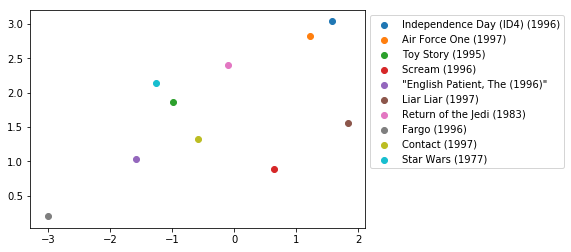

In [6]:
plot_projections(U_method1, V_method1)

movie_ids, counts = np.unique(Y_total[:,1], return_counts=True)
popularities = sorted(zip(movie_ids, counts),key = lambda x: x[1])
top_ids, top_counts = zip(*popularities[-10:])
plot_projections(U_method1, V_method1, False, np.array(top_ids, dtype='int') - 1)

## Visualize Method 2

In [ ]:
plot_projections(U_method2, V_method2)

movie_ids, counts = np.unique(Y_total[:,1], return_counts=True)
popularities = sorted(zip(movie_ids, counts),key = lambda x: x[1])
top_ids, top_counts = zip(*popularities[-10:])
plot_projections(U_method1, V_method1, False, np.array(top_ids, dtype='int') - 1)